In [ ]:
!pip install mpl_finance
!pip install yfinance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [2]:
import numpy as np, pandas as pd
# dataloader
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
# date
import datetime as dt
import matplotlib.dates as mdates
# stats
from scipy import stats
from scipy.stats import norm, skew
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
# visualization
from mpl_finance import candlestick_ohlc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
matplotlib.rc('figure', figsize=(16, 6))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Airbnb, Inc.
ticker = 'ABNB'
start = dt.datetime(2018, 1, 1)
end = dt.datetime.today()

df = pdr.get_data_yahoo(ticker, start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-10,146.000000,165.000000,141.250000,144.710007,144.710007,70447500
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600


In [4]:
df["target"] = df.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
df.head()

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2020-12-10,146.000000,165.000000,141.250000,144.710007,144.710007,70447500,NaN
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800,0.0
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100,0.0
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400,0.0
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600,1.0


In [5]:
df['Date'] = df.index
df['year'] = df.Date.dt.year
#df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
#df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
#df['day of week'] = df.Date.dt.dayofweek
years = df['year'].unique()

df.head()

,Open,High,Low,Close,Adj Close,Volume,target,Date,year,month,day
Date,,,,,,,,,,,
2020-12-10,146.000000,165.000000,141.250000,144.710007,144.710007,70447500,NaN,2020-12-10,2020,Dec,10
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800,0.0,2020-12-11,2020,Dec,11
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100,0.0,2020-12-14,2020,Dec,14
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400,0.0,2020-12-15,2020,Dec,15
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600,1.0,2020-12-16,2020,Dec,16


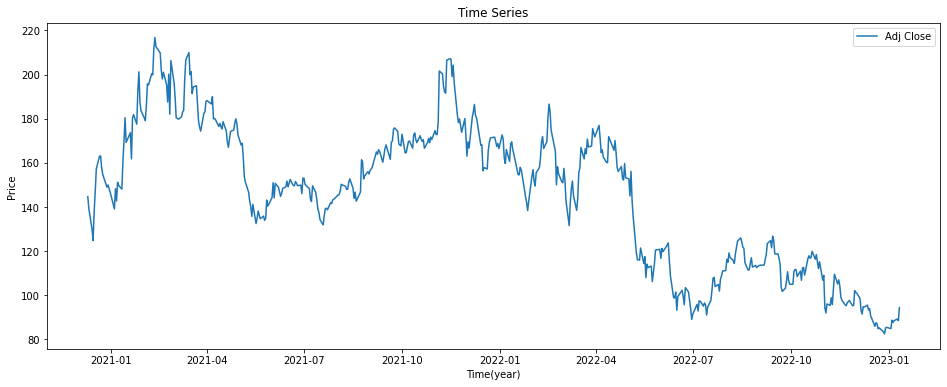

In [6]:
plt.plot(df['Adj Close'], label='Adj Close') 
plt.title('Time Series') 
plt.xlabel("Time(year)") 
plt.ylabel("Price") 
plt.legend(loc='best');

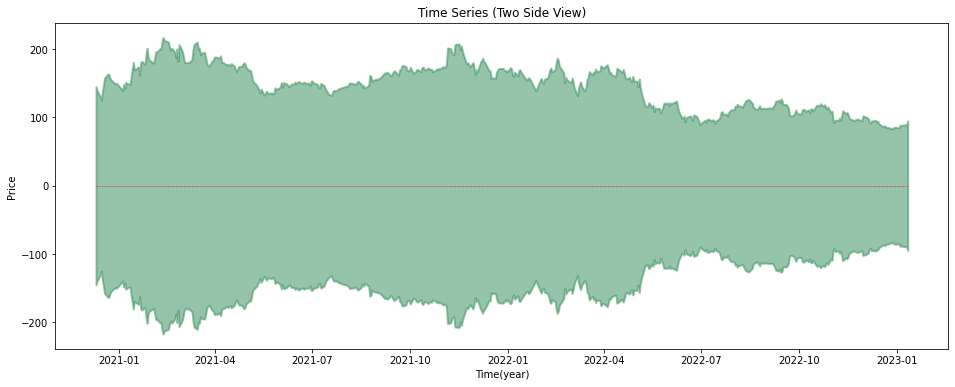

In [7]:
plt.fill_between(df.index, y1=df['Adj Close'], y2=-df['Adj Close'], alpha=0.5, linewidth=2, color='seagreen')
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5, color='r',linestyle='--');
plt.title('Time Series (Two Side View)');
plt.xlabel("Time(year)") 
plt.ylabel("Price");

Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

# Time resampling

Resampling involves **changing the frequency of time series observations**. 

Two types of resampling are:

1. **Upsampling**: Where you increase the frequency of the samples, such as from minutes to seconds. 
2. **Downsampling**: Where you decrease the frequency of the samples, such as from days to months.

,Open,High,Low,Close,Adj Close,Volume,target,year,day
Date,,,,,,,,,
2020-12-31,148.509600,155.123600,142.494135,147.626001,147.626001,1.545011e+07,0.428571,2020.0,20.600000
2021-12-31,167.566687,171.390500,163.620480,167.589802,167.589802,6.512850e+06,0.488095,2021.0,15.674603
2022-12-31,125.141052,128.234191,122.029789,125.099084,125.099084,6.447124e+06,0.474104,2022.0,15.645418
2023-12-31,88.341428,90.102857,86.577714,88.867143,88.867143,4.658102e+06,0.571429,2023.0,6.857143


Text(0.5, 1.0, 'Yearly Mean Adj Close for ABNB')

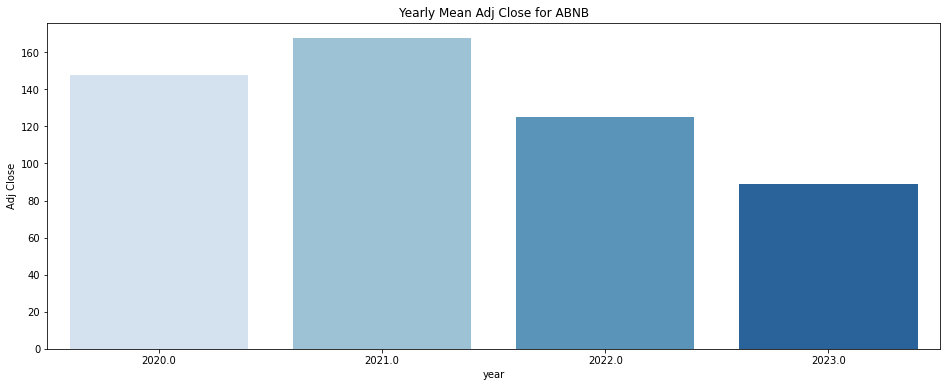

In [8]:
# he ‘A’ stands for year-end frequency, and denotes the offset values by which we want to resample the data.
a = df.resample(rule = 'A').mean()[:5]
display(a)

sns.barplot(
    x = 'year',
    y = 'Adj Close',
    data = a,
    palette = "Blues"
)
plt.title(f'Yearly Mean Adj Close for {ticker}')

# Forward Shifting

Sometimes, we may need to shift or move the data forward or backwards in time. 

This shifting is done along a time index by the desired number of time-frequency increments.

In [9]:
df.shift(1).head()
# Backwards shifting
#df.shift(-1).head()

,Open,High,Low,Close,Adj Close,Volume,target,Date,year,month,day
Date,,,,,,,,,,,
2020-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,None,NaN
2020-12-11,146.000000,165.000000,141.250000,144.710007,144.710007,70447500.0,NaN,2020-12-10,2020.0,Dec,10.0
2020-12-14,146.550003,151.500000,135.100006,139.250000,139.250000,26980800.0,0.0,2020-12-11,2020.0,Dec,11.0
2020-12-15,135.000000,135.300003,125.160004,130.000000,130.000000,16966100.0,0.0,2020-12-14,2020.0,Dec,14.0
2020-12-16,126.690002,127.599998,121.500000,124.800003,124.800003,10914400.0,0.0,2020-12-15,2020.0,Dec,15.0


# Calculate trend using Rolling windows

If there’s quite a bit of noise present. We could average this out by a week/month, which is where a rolling mean comes in.

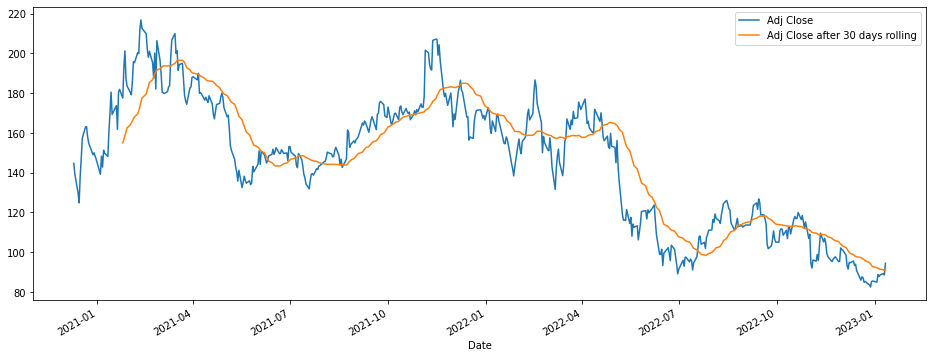

In [10]:
days = 30

df['Adj Close'].plot()
df.rolling(window=days).mean()['Adj Close'].plot()
plt.legend(['Adj Close', f'Adj Close after {days} days rolling']);

# Time series patterns

### Trend
A trend exists when there is a** long-term increase or decrease** in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.

### Seasonal
A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. **Seasonality is always of a fixed and known frequency.** 

### Cyclic
A cycle occurs when the data exhibit **rises and falls that are not of a fixed frequency**. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

# Detrending a time series
Detrending is a process of **eliminating the trend component from a time series,** where a **trend refers to a change in the mean over time** (a continuous decrease or increase over time). 

In [11]:
# hpfilter
df_cycle, df_trend = hpfilter(df['Adj Close'], lamb=600)
de_trend_hp = df['Adj Close'].values - df_trend
# seasonal_decompose
result_mul = seasonal_decompose(df['Adj Close'], model='multiplicative', extrapolate_trend='freq', period=int(len(df)/2))
de_trend_sd = df['Adj Close'].values - result_mul.trend
# diff
diff = df['Adj Close'].diff()
# signal
de_trend_si = signal.detrend(df['Adj Close'].values)

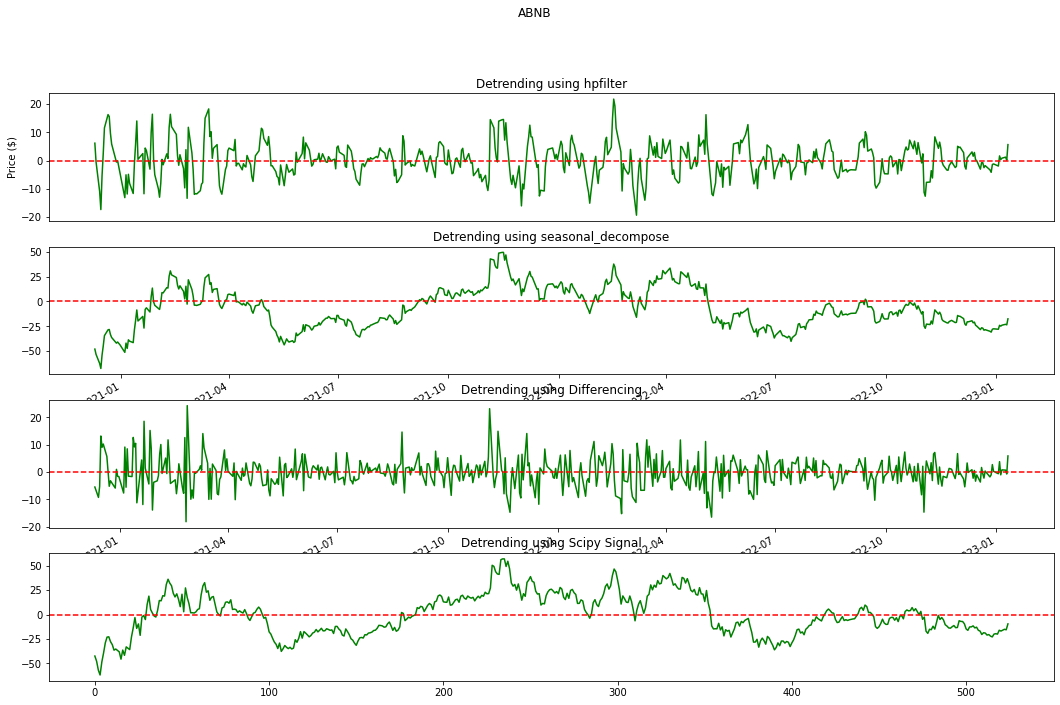

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(18, 12))
ax1.get_xaxis().set_visible(False)
fig.suptitle(ticker)

de_trend_hp.plot(c='g', ax=ax1, title = 'Detrending using hpfilter')
ax1.axhline(0, color='r', linestyle='--')
ax1.set_ylabel('Price ($)')

de_trend_sd.plot(c='g', ax=ax2, title = 'Detrending using seasonal_decompose')
ax2.axhline(0, color='r', linestyle='--');

diff.plot(c='g', ax=ax3, title = 'Detrending using Differencing')
ax3.axhline(0, color='r', linestyle='--')

ax4.plot(de_trend_si, c='g')
ax4.set_title('Detrending using Scipy Signal')
ax4.axhline(0, color='r', linestyle='--');

# De-seasonalize a time series

1.    **Take a moving average** with length as the seasonal window. This will smoothen in series in the process.

2.    **Seasonal difference** the series (subtract the value of previous season from the current value)

3.    **Divide the series by the seasonal index** obtained from STL decompositionSeasonal decomposition using moving averages.

In [13]:
deseason = df['Adj Close'] - result_mul.seasonal

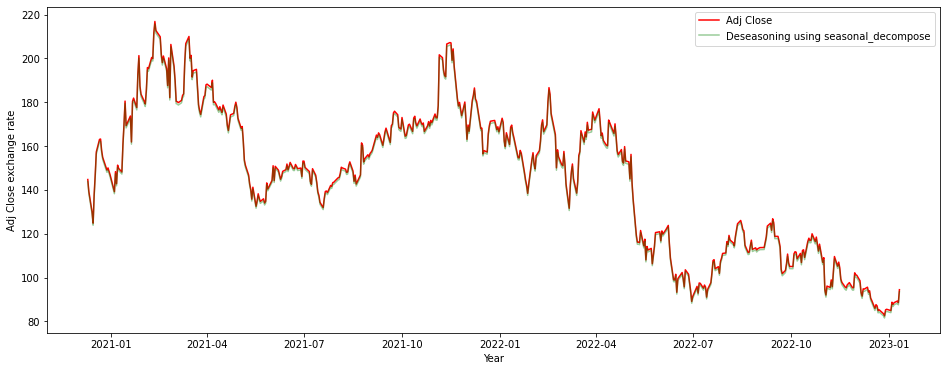

In [14]:
plt.plot(df['Adj Close'], c='r', label='Adj Close')
plt.plot(deseason, c='g', alpha=0.4, label='Deseasoning using seasonal_decompose')

plt.xlabel('Year')
plt.ylabel('Adj Close exchange rate')
plt.legend();

# Detecting cyclical variation

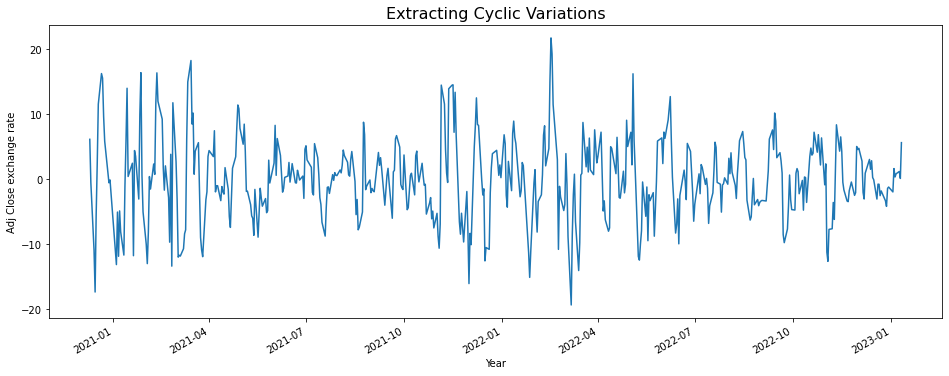

In [15]:
df_cycle.plot()
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Adj Close exchange rate');

# Autocorrelation Function (ACF) plot

1. **reveals definitive repeated spikes at the multiples of the seasonal window.**

2. **checking randomness** in a data set. 

This randomness is ascertained by computing autocorrelations for data values at varying time lags. 

    If random, such autocorrelations should be near zero for any and all time-lag separations.

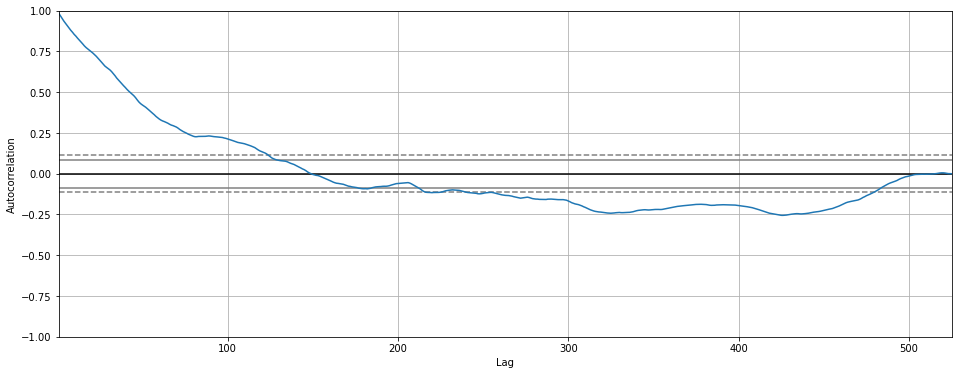

In [16]:
autocorrelation_plot(df['Adj Close'].tolist())

The horizontal lines in the plot correspond to 95% and 99% confidence bands.

The dashed line is 99% confidence band.